In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-05-18 20:46:15.930289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 20:46:16.795636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-18 20:46:16.795717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-18 20:46:16.795725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

Num GPUs Available:  1


2024-05-18 20:46:17.918479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-18 20:46:17.954910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-18 20:46:17.955470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# from datetime import datetime
# from influxdb_client import InfluxDBClient

# # url = 'http://14.50.47.229:48888'
# # org = 'ssafy'
# # bucket = 'ssafy'
# # token = 'XTcz2fflBDvHBkYepS-5Gdoe74xjt9D8F5ggeunKzaxxW-dKTEVRGXz8L1zvDIOJIcUdk0iYA863UmREJjjT8w=='
# # measurement = 'F1496'
# url = 'http://54.180.132.49:57277'
# org = 'ssafy'
# token = '9AXKggKqaG0j_xqFihdEQwCEePEb6_yj9okmniwnzlmPylETD1oGNDdf7OWt8of4nHxT9OA-pd5PyJtDoi7elQ=='
# measurement = 'MASS07'
# bucket = 'facility'
# client = InfluxDBClient(url=url, token=token, org=org)

# try:
#     # 버킷 목록 조회
#     buckets = client.buckets_api().find_buckets().buckets
#     print("Connection Successful. Buckets found:")
#     for bucket in buckets:
#         print(f" - {bucket.name}")
# except Exception as e:
#     print(f"Connection failed: {e}")
# finally:
#     client.close()

In [26]:
import json
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import datetime, timedelta
from influxdb_client import InfluxDBClient
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
train_data = pd.read_csv('train.csv', header=None)
test1_data = pd.read_csv('test1.csv', header=None)
test2_data = pd.read_csv('test2.csv', header=None)
print('done')

done


In [6]:
print(train_data.iloc[1:, 6])

1       0.000962
2         0.0823
3          0.152
4           0.18
5           0.19
          ...   
4530       0.175
4531       0.174
4532       0.175
4533       0.175
4534       0.175
Name: 6, Length: 4534, dtype: object


In [7]:
train = train_data.iloc[1:, 6]
test1 = test1_data.iloc[1:, 6]
test2 = test2_data.iloc[1:, 6]
print('done')

done


In [8]:
train = pd.to_numeric(train)
test1 = pd.to_numeric(test1)
test2 = pd.to_numeric(test2)

In [9]:
print(type(train))
print(type(test1))
print(type(test2))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [10]:
max_len = max(len(train), len(test1), len(test2))
print(max_len)
train = pd.concat([train, pd.Series([train.iloc[-1]] * (max_len - len(train)))], ignore_index=True)
test1 = pd.concat([test1, pd.Series([test1.iloc[-1]] * (max_len - len(test1)))], ignore_index=True)
# test2 = pd.concat([test2, pd.Series([test2.iloc[-1]] * (max_len - len(test2)))], ignore_index=True)

7118


In [11]:
print(len(train))
print(len(test1))
print(len(test2))

7118
7118
7118


In [32]:
######################################################
# minmax scale 안함
print(train.shape)
train_X = train.values.reshape((train.shape[0], 1, 1))
print(train_X.shape)

(7118,)
(7118, 1, 1)


In [39]:
def autoencoder_model(X):
    inputs = Input(shape=(1, 1))
    L1 = LSTM(24, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(10, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(10, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(24, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(1))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [40]:
# def autoencoder_model(X):
#     print(X.shape[1], X.shape[2])
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L1 = LSTM(24, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
#     L2 = LSTM(10, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=False)(L1)
#     L3 = RepeatVector(X.shape[1])(L2)
#     L4 = LSTM(10, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=True)(L3)
#     L5 = LSTM(24, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=True)(L4)
#     output = TimeDistributed(Dense(X.shape[2]))(L5)
#     model = Model(inputs=inputs, outputs=output)
#     return model

In [41]:
model = autoencoder_model(train_X)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 24)             2496      
                                                                 
 lstm_9 (LSTM)               (None, 10)                1400      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 10)            0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 1, 10)             840       
                                                                 
 lstm_11 (LSTM)              (None, 1, 24)             3360      
                                                           

In [42]:
model.compile(optimizer='adam', loss='mse')

In [43]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found")

Physical devices cannot be modified after being initialized


In [44]:
model.fit(train_X, train_X, epochs=10, batch_size=1)

Epoch 1/10
7118/7118 [==============================] - 45s 6ms/step - loss: 0.0089
Epoch 2/10
7118/7118 [==============================] - 41s 6ms/step - loss: 7.3444e-04
Epoch 3/10
7118/7118 [==============================] - 41s 6ms/step - loss: 3.2948e-04
Epoch 4/10
7118/7118 [==============================] - 39s 5ms/step - loss: 1.2309e-04
Epoch 5/10
7118/7118 [==============================] - 39s 5ms/step - loss: 4.5204e-05
Epoch 6/10
7118/7118 [==============================] - 40s 6ms/step - loss: 7.1082e-05
Epoch 7/10
7118/7118 [==============================] - 39s 6ms/step - loss: 8.8924e-05
Epoch 8/10
7118/7118 [==============================] - 39s 5ms/step - loss: 4.4295e-05
Epoch 9/10
7118/7118 [==============================] - 39s 6ms/step - loss: 5.1707e-05
Epoch 10/10
7118/7118 [==============================] - 39s 6ms/step - loss: 5.9729e-05


In [45]:
model.save("autoencoder_model.h5")

In [46]:
test1_X = test1.values.reshape((test1.shape[0], 1, 1))
test2_X = test2.values.reshape((test2.shape[0], 1, 1))

In [52]:
print(train_X.shape)
print(test1_X.shape)
print(test2_X.shape)

(7118, 1, 1)
(7118, 1, 1)
(7118, 1, 1)


In [53]:
# Anomaly threshold 계산
print('anomaly threshold = {}'.format(np.percentile(scored['Loss_mae'], 100)))
threshold = np.percentile(scored['Loss_mae'], 100)

# 테스트 데이터에 대한 예측 수행
X_pred = model.predict(test1_X)
X_pred = X_pred.reshape(test1_X.shape[0], -1)  # (7118, 1) 형태로 변환

# Loss 계산
Xtest = test1_X.reshape(test1_X.shape[0], -1)  # (7118, 1) 형태로 변환
loss_mae = np.mean(np.abs(X_pred - Xtest), axis=1)

# Threshold와 Anomaly 계산
scored = pd.DataFrame({
    'Loss_mae': loss_mae,
    'Threshold': threshold,
    'Anomaly': loss_mae > threshold
})

# 결과 출력
print(scored.head())

anomaly threshold = 0.9632110521197319
223/223 [==============================] - 0s 2ms/step
   Loss_mae  Threshold  Anomaly
0  0.048547   0.963211    False
1  0.014455   0.963211    False
2  0.002403   0.963211    False
3  0.001325   0.963211    False
4  0.002150   0.963211    False


/home/j-k10s107/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:772: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(self.ylim)


<Axes: >

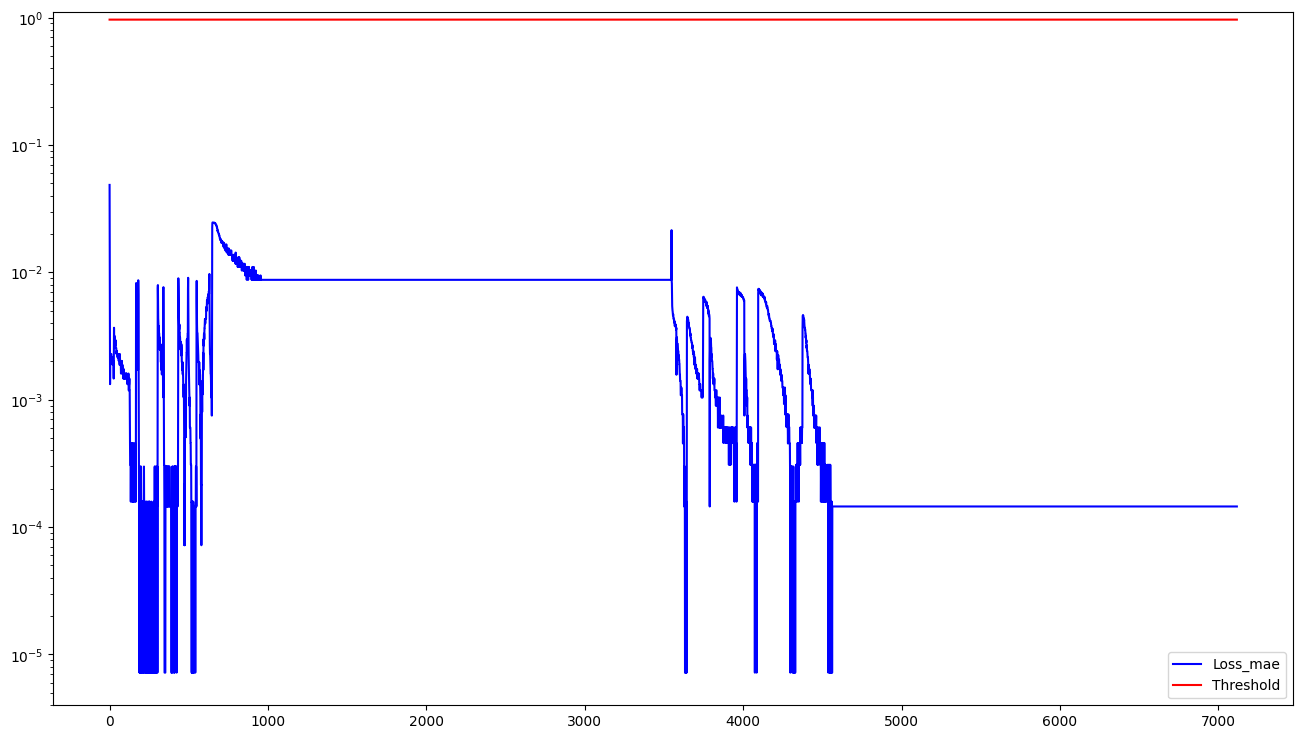

In [54]:
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

In [70]:
# Anomaly threshold 계산
print('anomaly threshold = {}'.format(np.percentile(scored['Loss_mae'], 100)))
threshold = np.percentile(scored['Loss_mae'], 100)

# 테스트 데이터에 대한 예측 수행
X_pred = model.predict(test2_X)
X_pred = X_pred.reshape(test2_X.shape[0], -1)  # (7118, 1) 형태로 변환

# Loss 계산
Xtest = test2_X.reshape(test2_X.shape[0], -1)  # (7118, 1) 형태로 변환
loss_mae = np.mean(np.abs(X_pred - Xtest), axis=1)

# Threshold와 Anomaly 계산
scored = pd.DataFrame({
    'Loss_mae': loss_mae,
    'Threshold': threshold,
    'Anomaly': loss_mae >= threshold
})

# 결과 출력
print(scored.head())

anomaly threshold = 0.048546525555849075
223/223 [==============================] - 0s 2ms/step
   Loss_mae  Threshold  Anomaly
0  0.049142   0.048547     True
1  0.017403   0.048547    False
2  0.006030   0.048547    False
3  0.000925   0.048547    False
4  0.000457   0.048547    False


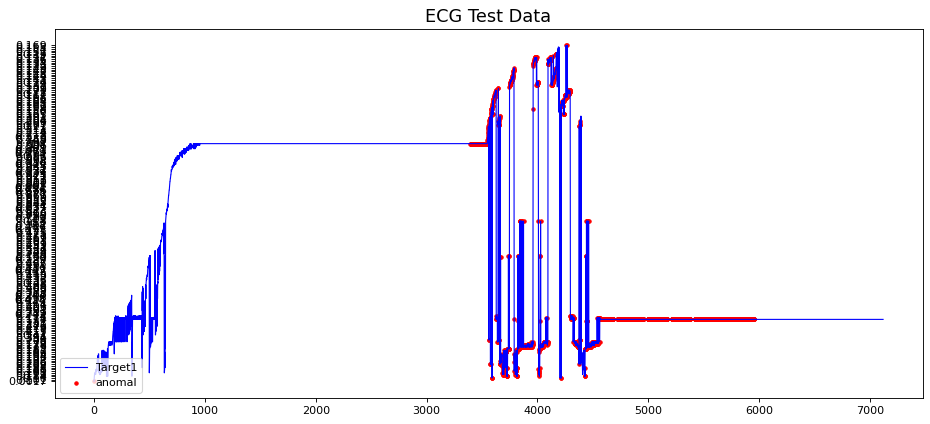

In [71]:
# 그래프 생성
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_, label='Target1', color='blue', animated=True, linewidth=1)
anomaly_indices = scored[scored['Anomaly'] == True].index
ax.scatter(anomaly_indices, test_[anomaly_indices], label='anomal', marker='.', color='red')
plt.legend(loc='lower left')
ax.set_title('ECG Test Data', fontsize=16)

# 레이블이 1인 구간 확인 및 표시
label_indices = test1_data[test1_data.iloc[:, -1] == 1].index
if len(label_indices) > 0:
    plt.axvspan(min(label_indices), max(label_indices), facecolor='gray', alpha=0.3)

plt.show()

/home/j-k10s107/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:772: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(self.ylim)


<Axes: >

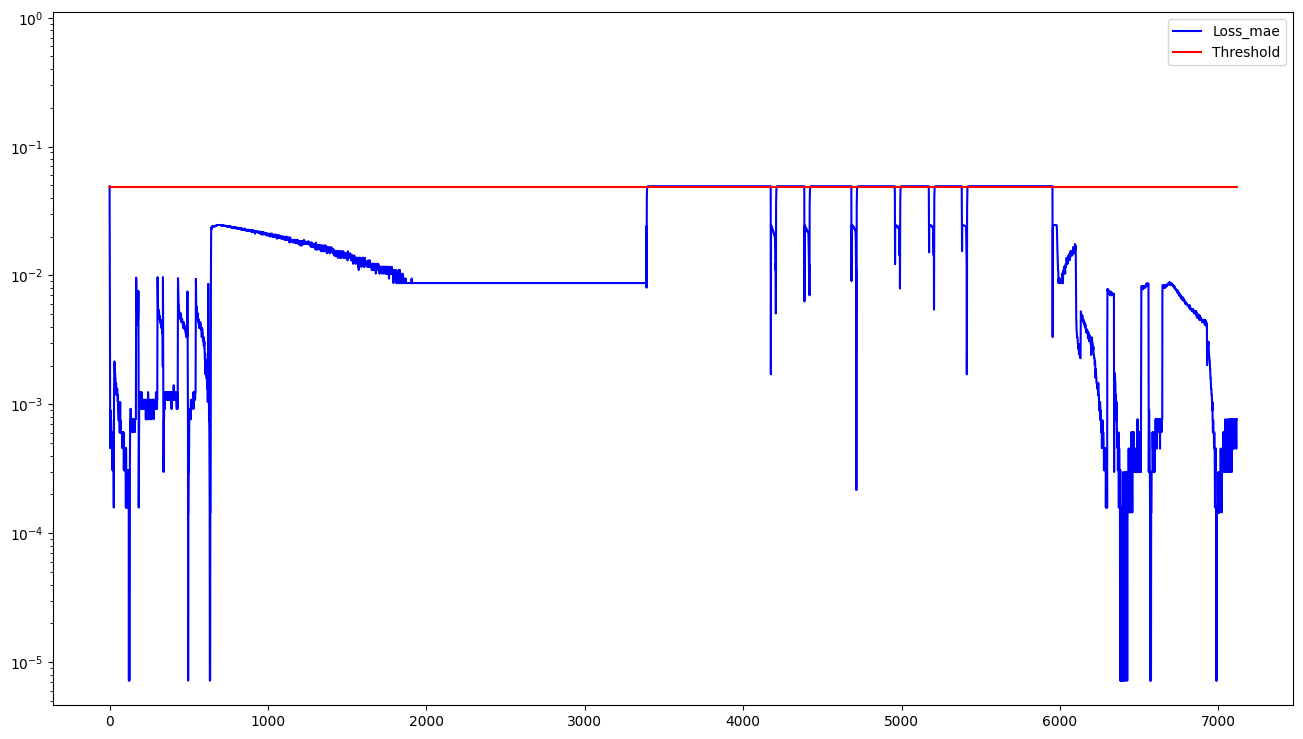

In [65]:
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

anomaly threshold = 0.04924706262564659
223/223 [==============================] - 0s 2ms/step


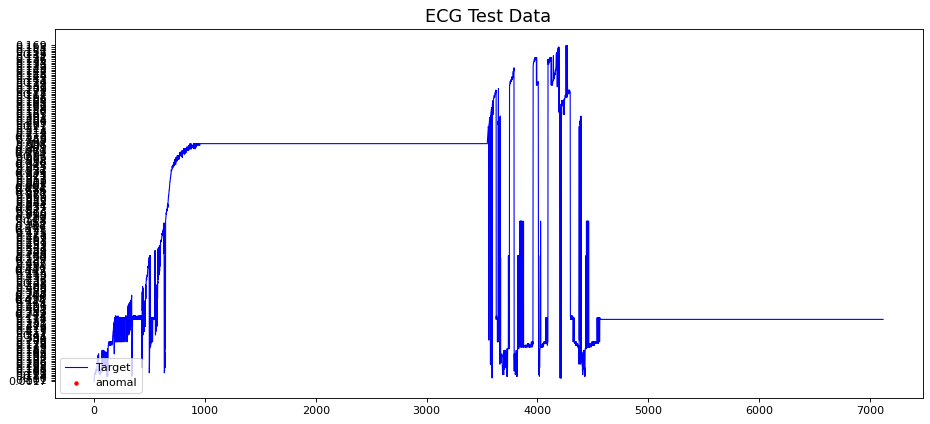

In [66]:
# test_를 시리즈로 설정
test_ = test1_data.iloc[1:, 6]
test_ = pd.concat([test_, pd.Series([test_.iloc[-1]] * (max_len - len(test_)))], ignore_index=True)

# Anomaly threshold 계산
print('anomaly threshold = {}'.format(np.percentile(scored['Loss_mae'], 100)))
threshold = np.percentile(scored['Loss_mae'], 100)

# 테스트 데이터에 대한 예측 수행
X_pred = model.predict(test1_X)
X_pred = X_pred.reshape(test1_X.shape[0], -1)  # (7118, 1) 형태로 변환

# Loss 계산
Xtest = test1_X.reshape(test1_X.shape[0], -1)  # (7118, 1) 형태로 변환
loss_mae = np.mean(np.abs(X_pred - Xtest), axis=1)

# Threshold와 Anomaly 계산
scored = pd.DataFrame({
    'Loss_mae': loss_mae,
    'Threshold': threshold,
    'Anomaly': loss_mae > threshold
})

# 인덱스 맞추기
scored.index = test_.index

# 그래프 생성
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_, label='Target', color='blue', animated=True, linewidth=1)
ax.scatter(test_[scored['Anomaly'] == 1].index, test_[scored['Anomaly'] == 1], label='anomal', marker='.', color='red')
plt.legend(loc='lower left')
ax.set_title('ECG Test Data', fontsize=16)

# 레이블이 1인 구간 확인 및 표시
label_indices = test1_data[test1_data.iloc[:, -1] == 1].index
if len(label_indices) > 0:
    plt.axvspan(min(label_indices), max(label_indices), facecolor='gray', alpha=0.3)

plt.show()


In [67]:
# Anomaly 값이 True인 데이터 출력
print(scored[scored['Anomaly'] == True])

Empty DataFrame
Columns: [Loss_mae, Threshold, Anomaly]
Index: []
